# 🧠 Customer Data Analysis — RFM, Churn Prediction, Segmentation

In [1]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

In [2]:
# STEP 2: Load Data
df = pd.read_csv('D:/Desktop/GenAI-Powered Analytics Platform/Data/raw/customer_data.csv', parse_dates=['signup_date', 'last_purchase_date'])
print('Shape:', df.shape)
df.info()
df.head()

Shape: (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         10000 non-null  object        
 1   customer_name       10000 non-null  object        
 2   gender              10000 non-null  object        
 3   age                 10000 non-null  int64         
 4   city                10000 non-null  object        
 5   state               10000 non-null  object        
 6   country             10000 non-null  object        
 7   signup_date         10000 non-null  datetime64[ns]
 8   last_purchase_date  9962 non-null   datetime64[ns]
 9   loyalty_score       10000 non-null  float64       
 10  total_orders        10000 non-null  int64         
 11  total_spent         10000 non-null  float64       
 12  churn_status        10000 non-null  bool          
 13  preferred_channel   10000 no

,customer_id,customer_name,gender,age,city,state,country,signup_date,last_purchase_date,loyalty_score,total_orders,total_spent,churn_status,preferred_channel
0,CUST-59825,Nancy Jones,Female,44,Munich,Bavaria,Germany,2021-02-04,2024-11-21,0.67,7,6880.11,False,Email
1,CUST-53379,Steven Jones,Male,58,Singapore,Singapore,Singapore,2021-02-24,2024-12-14,0.61,5,5266.66,False,SMS
2,CUST-56158,Richard Wilson,Male,48,Zaragoza,Valencia,Spain,2020-05-24,2024-09-27,0.67,5,14427.26,False,Email
3,CUST-53695,Mary Davis,Female,48,Fortaleza,São Paulo,Brazil,2020-04-26,2024-10-28,0.64,4,8279.39,False,SMS
4,CUST-51921,Lisa Jones,Female,23,Barcelona,Valencia,Spain,2021-10-07,2024-08-31,0.47,5,4285.52,False,Email


C:\Users\akasar\AppData\Local\Temp\1\ipykernel_11476\350464046.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, palette='pastel')


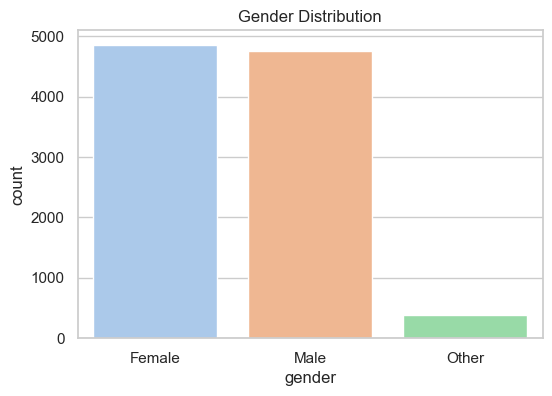

C:\Users\akasar\AppData\Local\Temp\1\ipykernel_11476\350464046.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn_status', data=df, palette='coolwarm')


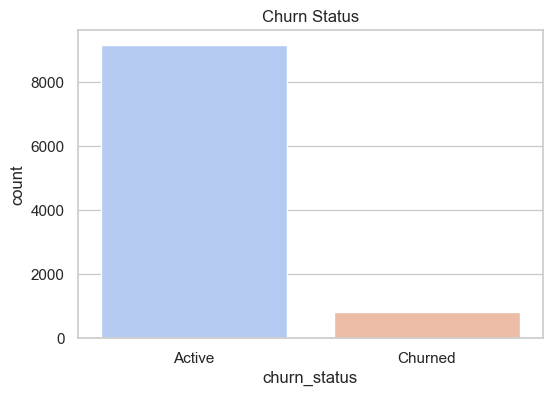

In [3]:
# STEP 3: EDA
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df, palette='pastel')
plt.title('Gender Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='churn_status', data=df, palette='coolwarm')
plt.title('Churn Status')
plt.xticks([0,1], ['Active','Churned'])
plt.show()

In [7]:
# STEP 4: RFM-like analysis (Updated and Robust Version)

import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute Recency, Frequency, Monetary
reference_date = df['last_purchase_date'].max() + pd.Timedelta(days=1)

rfm = df[['customer_id', 'last_purchase_date', 'total_orders', 'total_spent']].copy()
rfm['Recency'] = (reference_date - rfm['last_purchase_date']).dt.days
rfm['Frequency'] = rfm['total_orders']
rfm['Monetary'] = rfm['total_spent']

# Step 2: Handle missing or invalid values
rfm = rfm.dropna(subset=['Recency', 'Frequency', 'Monetary'])
rfm = rfm[rfm['Monetary'] > 0]  # Remove zero-spend customers if any

# Step 3: Create R, F, M Scores using rank to avoid duplicate bin issues
rfm['R_score'] = pd.qcut(rfm['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Step 4: Combine into RFM Score
rfm['RFM_score'] = rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)

# Step 5: Segment customers based on RFM Score
def rfm_label(x):
    if x >= 13:
        return 'Champions'
    elif x >= 10:
        return 'Loyal'
    elif x >= 7:
        return 'Potential'
    elif x >= 5:
        return 'At Risk'
    else:
        return 'Lost'

rfm['segment'] = rfm['RFM_score'].apply(rfm_label)

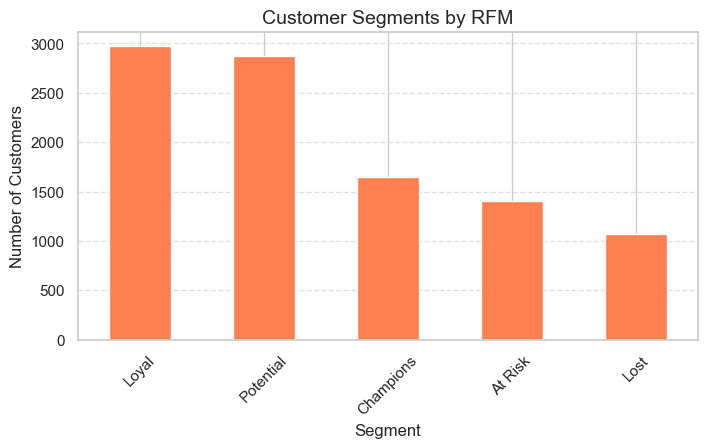

              Recency  Frequency      Monetary  Num_Customers
segment                                                      
Champions   19.999392   7.859489  24274.108936           1644
Loyal       45.972400   6.016493  15563.773265           2971
Potential   70.985744   4.319541   9282.556905           2876
At Risk    112.509286   3.236429   5115.218057           1400
Lost       184.323996   2.180205   2341.631455           1071


In [9]:
# Step 6: Display Segment Distribution
plt.figure(figsize=(8,4))
rfm['segment'].value_counts().sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Customer Segments by RFM', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Step 7: Optional Summary Table
segment_summary = (
    rfm.groupby('segment')
       .agg({
           'Recency': 'mean',
           'Frequency': 'mean',
           'Monetary': 'mean',
           'customer_id': 'count'
       })
       .rename(columns={'customer_id': 'Num_Customers'})
       .sort_values('Monetary', ascending=False)
)

print(segment_summary)

In [5]:
# STEP 5: Churn Prediction
features = ['age','loyalty_score','total_orders','total_spent']
X = df[features]
y = df['churn_status'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9915
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1830
           1       0.98      0.92      0.95       170

    accuracy                           0.99      2000
   macro avg       0.98      0.96      0.97      2000
weighted avg       0.99      0.99      0.99      2000

